In [22]:
class TickData(object):
    def __init__(self, timestamp='', symbol='',open_price=0, close_price=0, total_volume=0):
        self.symbol = symbol
        self.timestamp = timestamp
        self.open_price = open_price
        self.close_price = close_price
        self.total_volume = total_volume

In [23]:
class MarketData(object):
    def __init__(self):
        self.recent_ticks = dict()  # indexed by symbol

    def add_tick_data(self, tick_data):
        self.recent_ticks[tick_data.symbol] = tick_data

    def get_open_price(self, symbol):
        return self.get_tick_data(symbol).open_price

    def get_close_price(self, symbol):
        return self.get_tick_data(symbol).close_price

    def get_tick_data(self, symbol):
        return self.recent_ticks.get(symbol, TickData())

    def get_timestamp(self, symbol):
        return self.recent_ticks[symbol].timestamp

In [24]:
class MarketDataSource(object):
    def __init__(self, symbol, tick_event_handler=None, start='', end=''):
        self.market_data = MarketData()

        self.symbol = symbol
        self.tick_event_handler = tick_event_handler
        self.start, self.end = start, end
        self.df = None

    def fetch_historical_prices(self):
        import quandl

        # Update your Quandl API key here...
        QUANDL_API_KEY = 'DiR9T6YCJ55Gfr_mh7cR'
        quandl.ApiConfig.api_key = QUANDL_API_KEY
        df = quandl.get(self.symbol, start_date=self.start, end_date=self.end)
        return df
    
    def fet_csv_data(self):
        data_path = "D:\\Users\\srhirj\\Work\\torodata\\data\\"
        data = pd.read_csv(data_path+ self.symbol +".csv", index_col="Date", parse_dates=True)
        return data[self.start:self.end]

    def run(self):
        if self.df is None:
            #self.df = self.fetch_historical_prices()
            self.df = self.fet_csv_data()

        total_ticks = len(self.df)
        print('Processing total_ticks:', total_ticks)

        for timestamp, row in self.df.iterrows():
            open_price = row['Open']
            close_price = row['Close']
            volume = row['Volume']

            print(timestamp.date(), 'TICK', self.symbol,
                  'open:', open_price,
                  'close:', close_price)
            tick_data = TickData(timestamp, self.symbol, open_price,
                                close_price, volume)
            self.market_data.add_tick_data(tick_data)

            if self.tick_event_handler:
                self.tick_event_handler(self.market_data)

In [7]:
class Order(object):
	def __init__(self, timestamp, symbol, 
		qty, is_buy, is_market_order, 
		price=0
	):
		self.timestamp = timestamp
		self.symbol = symbol
		self.qty = qty
		self.price = price
		self.is_buy = is_buy
		self.is_market_order = is_market_order
		self.is_filled = False
		self.filled_price = 0
		self.filled_time = None
		self.filled_qty = 0

In [8]:
class Position(object):
	def __init__(self, symbol=''):
		self.symbol = symbol
		self.buys = self.sells = self.net = 0
		self.rpnl = 0
		self.position_value = 0

	def on_position_event(self, is_buy, qty, price):
		if is_buy:
			self.buys += qty
		else:
			self.sells += qty

		self.net = self.buys - self.sells
		changed_value = qty * price * (-1 if is_buy else 1)
		self.position_value += changed_value

		if self.net == 0:
			self.rpnl = self.position_value
			self.position_value = 0

	def calculate_unrealized_pnl(self, price):
		if self.net == 0:
			return 0

		market_value = self.net * price
		upnl = self.position_value + market_value
		return upnl

In [9]:
from abc import abstractmethod

class Strategy:
	def __init__(self, send_order_event_handler):
		self.send_order_event_handler = send_order_event_handler

	@abstractmethod
	def on_tick_event(self, market_data):
		raise NotImplementedError('Method is required!')

	@abstractmethod
	def on_position_event(self, positions):
		raise NotImplementedError('Method is required!')

	def send_market_order(self, symbol, qty, is_buy, timestamp):
		if self.send_order_event_handler:
			order = Order(
				timestamp,
				symbol,
				qty,
				is_buy,
				is_market_order=True,
				price=0,
			)
			self.send_order_event_handler(order)

In [32]:
import pandas as pd

class MeanRevertingStrategy(Strategy):
    def __init__(self, symbol, trade_qty,
        send_order_event_handler=None, lookback_intervals=20,
        buy_threshold=-0.5, sell_threshold=0.5
    ):
        super(MeanRevertingStrategy, self).__init__(
            send_order_event_handler)

        self.symbol = symbol
        self.trade_qty = trade_qty
        self.lookback_intervals = lookback_intervals
        self.buy_threshold = buy_threshold
        self.sell_threshold = sell_threshold

        self.prices = pd.DataFrame()
        self.is_long = self.is_short = False

    def on_position_event(self, positions):
        position = positions.get(self.symbol)

        self.is_long = position and position.net > 0
        self.is_short = position and position.net < 0

    def on_tick_event(self, market_data):
        self.store_prices(market_data)

        if len(self.prices) < self.lookback_intervals:
            return

        self.generate_signals_and_send_order(market_data)

    def store_prices(self, market_data):
        timestamp = market_data.get_timestamp(self.symbol)
        close_price = market_data.get_close_price(self.symbol)
        self.prices.loc[timestamp, 'close'] = close_price

    def generate_signals_and_send_order(self, market_data):
        signal_value = self.calculate_z_score()
        timestamp = market_data.get_timestamp(self.symbol)

        if self.buy_threshold > signal_value and not self.is_long:
            print(timestamp.date(), 'BUY signal')
            self.send_market_order(
                self.symbol, self.trade_qty, True, timestamp)
        elif self.sell_threshold < signal_value and not self.is_short:
            print(timestamp.date(), 'SELL signal')
            self.send_market_order(
                self.symbol, self.trade_qty, False, timestamp)

    def calculate_z_score(self):
        self.prices = self.prices[-self.lookback_intervals:]
        returns = self.prices['close'].pct_change().dropna()
        z_score = ((returns - returns.mean()) / returns.std())[-1]
        return z_score

In [34]:
class BacktestEngine:
	def __init__(self, symbol, trade_qty, start='', end=''):
		self.symbol = symbol
		self.trade_qty = trade_qty
		self.market_data_source = MarketDataSource(
			symbol,
			tick_event_handler=self.on_tick_event,
			start=start, end=end
		)

		self.strategy = None
		self.unfilled_orders = []
		self.positions = dict()
		self.df_rpnl = None
        
	def start(self, **kwargs):
		print('Backtest started...')

		self.unfilled_orders = []
		self.positions = dict()
		self.df_rpnl = pd.DataFrame()

		self.strategy = MeanRevertingStrategy(
			self.symbol,
			self.trade_qty,
			send_order_event_handler=self.on_order_received,
			**kwargs
		)
		self.market_data_source.run()

		print('Backtest completed.')
        
	def on_order_received(self, order):
		""" Adds an order to the order book """
		print(
			order.timestamp.date(),
			'ORDER',
			'BUY' if order.is_buy else 'SELL',
			order.symbol,
			order.qty
		)
		self.unfilled_orders.append(order)
        
	def on_tick_event(self, market_data):
		self.match_order_book(market_data)
		self.strategy.on_tick_event(market_data)
		self.print_position_status(market_data)
        
	def match_order_book(self, market_data):
		if len(self.unfilled_orders) > 0:
			self.unfilled_orders = [
				order for order in self.unfilled_orders
				if self.match_unfilled_orders(order, market_data)
			]
            
	def match_unfilled_orders(self, order, market_data):
		symbol = order.symbol
		timestamp = market_data.get_timestamp(symbol)

		""" Order is matched and filled """
		if order.is_market_order and timestamp > order.timestamp:
			open_price = market_data.get_open_price(symbol)

			order.is_filled = True
			order.filled_timestamp = timestamp
			order.filled_price = open_price

			self.on_order_filled(
				symbol, order.qty, order.is_buy,
				open_price, timestamp
			)
			return False

		return True
    
	def on_order_filled(self, symbol, qty, is_buy, filled_price, timestamp):
		position = self.get_position(symbol)
		position.on_position_event(is_buy, qty, filled_price)
		self.df_rpnl.loc[timestamp, "rpnl"] = position.rpnl

		self.strategy.on_position_event(self.positions)

		print(
			timestamp.date(),
			'FILLED', "BUY" if is_buy else "SELL",
			qty, symbol, 'at', filled_price
		)
        
	def get_position(self, symbol):
		if symbol not in self.positions:
			self.positions[symbol] = Position(symbol)

		return self.positions[symbol]
    
	def print_position_status(self, market_data):
		for symbol, position in self.positions.items():
			close_price = market_data.get_close_price(symbol)
			timestamp = market_data.get_timestamp(symbol)

			upnl = position.calculate_unrealized_pnl(close_price)

			print(
				timestamp.date(),
				'POSITION',
				'value:%.3f' % position.position_value,
				'upnl:%.3f' % upnl,
				'rpnl:%.3f' % position.rpnl
			)

In [38]:
engine = BacktestEngine(
    'BBL', 100,
    start='2015-01-01',
    end='2017-12-31'
)

In [39]:
engine.start(
    lookback_intervals=20,
    buy_threshold=-1.5,
    sell_threshold=1.5
)

Backtest started...
Processing total_ticks: 731
2015-01-05 TICK BBL open: 193.0 close: 190.0
2015-01-06 TICK BBL open: 188.0 close: 189.5
2015-01-07 TICK BBL open: 189.0 close: 191.5
2015-01-08 TICK BBL open: 192.5 close: 192.0
2015-01-09 TICK BBL open: 192.0 close: 190.0
2015-01-12 TICK BBL open: 190.0 close: 188.0
2015-01-13 TICK BBL open: 187.0 close: 186.5
2015-01-14 TICK BBL open: 187.0 close: 186.5
2015-01-15 TICK BBL open: 187.0 close: 186.0
2015-01-16 TICK BBL open: 185.0 close: 183.5
2015-01-19 TICK BBL open: 184.5 close: 184.0
2015-01-20 TICK BBL open: 184.5 close: 185.0
2015-01-21 TICK BBL open: 186.0 close: 185.5
2015-01-22 TICK BBL open: 186.5 close: 188.0
2015-01-23 TICK BBL open: 189.0 close: 193.5
2015-01-26 TICK BBL open: 193.5 close: 194.0
2015-01-27 TICK BBL open: 195.0 close: 196.0
2015-01-28 TICK BBL open: 195.5 close: 193.5
2015-01-29 TICK BBL open: 194.0 close: 192.5
2015-01-30 TICK BBL open: 192.0 close: 190.5
2015-02-02 TICK BBL open: 188.0 close: 189.5
2015-02

2015-06-04 POSITION value:0.000 upnl:0.000 rpnl:300.000
2015-06-05 TICK BBL open: 181.0 close: 181.0
2015-06-05 POSITION value:0.000 upnl:0.000 rpnl:300.000
2015-06-08 TICK BBL open: 181.0 close: 180.0
2015-06-08 POSITION value:0.000 upnl:0.000 rpnl:300.000
2015-06-09 TICK BBL open: 180.0 close: 179.5
2015-06-09 POSITION value:0.000 upnl:0.000 rpnl:300.000
2015-06-10 TICK BBL open: 180.0 close: 180.5
2015-06-10 POSITION value:0.000 upnl:0.000 rpnl:300.000
2015-06-11 TICK BBL open: 181.5 close: 180.5
2015-06-11 POSITION value:0.000 upnl:0.000 rpnl:300.000
2015-06-12 TICK BBL open: 180.0 close: 180.0
2015-06-12 POSITION value:0.000 upnl:0.000 rpnl:300.000
2015-06-15 TICK BBL open: 180.0 close: 180.0
2015-06-15 POSITION value:0.000 upnl:0.000 rpnl:300.000
2015-06-16 TICK BBL open: 179.5 close: 179.5
2015-06-16 POSITION value:0.000 upnl:0.000 rpnl:300.000
2015-06-17 TICK BBL open: 180.0 close: 180.0
2015-06-17 POSITION value:0.000 upnl:0.000 rpnl:300.000
2015-06-18 TICK BBL open: 179.5 clo

2015-09-23 POSITION value:17250.000 upnl:950.000 rpnl:50.000
2015-09-24 TICK BBL open: 162.5 close: 164.5
2015-09-24 POSITION value:17250.000 upnl:800.000 rpnl:50.000
2015-09-25 TICK BBL open: 163.5 close: 163.0
2015-09-25 POSITION value:17250.000 upnl:950.000 rpnl:50.000
2015-09-28 TICK BBL open: 162.0 close: 161.0
2015-09-28 POSITION value:17250.000 upnl:1150.000 rpnl:50.000
2015-09-29 TICK BBL open: 160.0 close: 160.0
2015-09-29 POSITION value:17250.000 upnl:1250.000 rpnl:50.000
2015-09-30 TICK BBL open: 160.5 close: 160.0
2015-09-30 POSITION value:17250.000 upnl:1250.000 rpnl:50.000
2015-10-01 TICK BBL open: 161.0 close: 159.0
2015-10-01 POSITION value:17250.000 upnl:1350.000 rpnl:50.000
2015-10-02 TICK BBL open: 159.0 close: 159.5
2015-10-02 POSITION value:17250.000 upnl:1300.000 rpnl:50.000
2015-10-05 TICK BBL open: 161.0 close: 161.5
2015-10-05 POSITION value:17250.000 upnl:1100.000 rpnl:50.000
2015-10-06 TICK BBL open: 162.0 close: 163.0
2015-10-06 POSITION value:17250.000 upnl

2016-01-22 POSITION value:0.000 upnl:0.000 rpnl:350.000
2016-01-25 TICK BBL open: 147.0 close: 145.5
2016-01-25 POSITION value:0.000 upnl:0.000 rpnl:350.000
2016-01-26 TICK BBL open: 144.5 close: 145.5
2016-01-26 POSITION value:0.000 upnl:0.000 rpnl:350.000
2016-01-27 TICK BBL open: 146.5 close: 149.0
2016-01-27 POSITION value:0.000 upnl:0.000 rpnl:350.000
2016-01-28 TICK BBL open: 149.5 close: 151.5
2016-01-28 POSITION value:0.000 upnl:0.000 rpnl:350.000
2016-01-29 TICK BBL open: 151.5 close: 152.5
2016-01-29 POSITION value:0.000 upnl:0.000 rpnl:350.000
2016-02-01 TICK BBL open: 152.0 close: 150.5
2016-02-01 POSITION value:0.000 upnl:0.000 rpnl:350.000
2016-02-02 TICK BBL open: 150.5 close: 148.5
2016-02-02 POSITION value:0.000 upnl:0.000 rpnl:350.000
2016-02-03 TICK BBL open: 147.0 close: 147.5
2016-02-03 POSITION value:0.000 upnl:0.000 rpnl:350.000
2016-02-04 TICK BBL open: 148.5 close: 151.0
2016-02-04 POSITION value:0.000 upnl:0.000 rpnl:350.000
2016-02-05 TICK BBL open: 151.5 clo

2016-05-26 POSITION value:0.000 upnl:0.000 rpnl:-1200.000
2016-05-27 TICK BBL open: 159.0 close: 160.5
2016-05-27 POSITION value:0.000 upnl:0.000 rpnl:-1200.000
2016-05-30 TICK BBL open: 161.5 close: 164.0
2016-05-30 POSITION value:0.000 upnl:0.000 rpnl:-1200.000
2016-05-31 TICK BBL open: 164.0 close: 163.5
2016-05-31 POSITION value:0.000 upnl:0.000 rpnl:-1200.000
2016-06-01 TICK BBL open: 163.0 close: 163.0
2016-06-01 POSITION value:0.000 upnl:0.000 rpnl:-1200.000
2016-06-02 TICK BBL open: 162.5 close: 162.0
2016-06-02 POSITION value:0.000 upnl:0.000 rpnl:-1200.000
2016-06-03 TICK BBL open: 162.5 close: 163.0
2016-06-03 POSITION value:0.000 upnl:0.000 rpnl:-1200.000
2016-06-06 TICK BBL open: 164.0 close: 165.5
2016-06-06 POSITION value:0.000 upnl:0.000 rpnl:-1200.000
2016-06-07 TICK BBL open: 166.5 close: 165.0
2016-06-07 POSITION value:0.000 upnl:0.000 rpnl:-1200.000
2016-06-08 TICK BBL open: 165.0 close: 164.5
2016-06-08 POSITION value:0.000 upnl:0.000 rpnl:-1200.000
2016-06-09 TICK

2016-09-14 POSITION value:17100.000 upnl:300.000 rpnl:-150.000
2016-09-15 TICK BBL open: 167.5 close: 167.0
2016-09-15 POSITION value:17100.000 upnl:400.000 rpnl:-150.000
2016-09-16 TICK BBL open: 167.0 close: 168.0
2016-09-16 POSITION value:17100.000 upnl:300.000 rpnl:-150.000
2016-09-19 TICK BBL open: 168.0 close: 168.0
2016-09-19 POSITION value:17100.000 upnl:300.000 rpnl:-150.000
2016-09-20 TICK BBL open: 167.5 close: 166.0
2016-09-20 POSITION value:17100.000 upnl:500.000 rpnl:-150.000
2016-09-21 TICK BBL open: 166.5 close: 166.5
2016-09-21 POSITION value:17100.000 upnl:450.000 rpnl:-150.000
2016-09-22 TICK BBL open: 168.5 close: 168.0
2016-09-22 POSITION value:17100.000 upnl:300.000 rpnl:-150.000
2016-09-23 TICK BBL open: 167.0 close: 167.0
2016-09-23 POSITION value:17100.000 upnl:400.000 rpnl:-150.000
2016-09-26 TICK BBL open: 164.0 close: 164.5
2016-09-26 POSITION value:17100.000 upnl:650.000 rpnl:-150.000
2016-09-27 TICK BBL open: 164.5 close: 163.0
2016-09-27 POSITION value:17

2017-01-09 POSITION value:16300.000 upnl:-100.000 rpnl:350.000
2017-01-10 TICK BBL open: 164.5 close: 168.0
2017-01-10 POSITION value:16300.000 upnl:-500.000 rpnl:350.000
2017-01-11 TICK BBL open: 168.5 close: 167.0
2017-01-11 POSITION value:16300.000 upnl:-400.000 rpnl:350.000
2017-01-12 TICK BBL open: 167.0 close: 166.0
2017-01-12 POSITION value:16300.000 upnl:-300.000 rpnl:350.000
2017-01-13 TICK BBL open: 167.0 close: 169.0
2017-01-13 POSITION value:16300.000 upnl:-600.000 rpnl:350.000
2017-01-16 TICK BBL open: 169.0 close: 168.5
2017-01-16 POSITION value:16300.000 upnl:-550.000 rpnl:350.000
2017-01-17 TICK BBL open: 166.5 close: 167.0
2017-01-17 POSITION value:16300.000 upnl:-400.000 rpnl:350.000
2017-01-18 TICK BBL open: 166.0 close: 166.0
2017-01-18 POSITION value:16300.000 upnl:-300.000 rpnl:350.000
2017-01-19 TICK BBL open: 166.0 close: 166.0
2017-01-19 POSITION value:16300.000 upnl:-300.000 rpnl:350.000
2017-01-20 TICK BBL open: 165.0 close: 168.5
2017-01-20 POSITION value:16

2017-05-03 POSITION value:-17900.000 upnl:150.000 rpnl:500.000
2017-05-04 TICK BBL open: 181.0 close: 182.0
2017-05-04 POSITION value:-17900.000 upnl:300.000 rpnl:500.000
2017-05-05 TICK BBL open: 181.5 close: 181.5
2017-05-05 POSITION value:-17900.000 upnl:250.000 rpnl:500.000
2017-05-08 TICK BBL open: 181.5 close: 181.5
2017-05-08 POSITION value:-17900.000 upnl:250.000 rpnl:500.000
2017-05-09 TICK BBL open: 182.0 close: 180.5
2017-05-09 POSITION value:-17900.000 upnl:150.000 rpnl:500.000
2017-05-11 TICK BBL open: 182.0 close: 181.5
2017-05-11 POSITION value:-17900.000 upnl:250.000 rpnl:500.000
2017-05-12 TICK BBL open: 181.0 close: 179.0
2017-05-12 POSITION value:-17900.000 upnl:0.000 rpnl:500.000
2017-05-15 TICK BBL open: 178.0 close: 179.5
2017-05-15 POSITION value:-17900.000 upnl:50.000 rpnl:500.000
2017-05-16 TICK BBL open: 178.5 close: 178.0
2017-05-16 POSITION value:-17900.000 upnl:-100.000 rpnl:500.000
2017-05-17 TICK BBL open: 178.0 close: 179.5
2017-05-17 POSITION value:-179

2017-08-24 POSITION value:0.000 upnl:0.000 rpnl:500.000
2017-08-25 TICK BBL open: 181.5 close: 181.5
2017-08-25 POSITION value:0.000 upnl:0.000 rpnl:500.000
2017-08-28 TICK BBL open: 182.0 close: 183.0
2017-08-28 POSITION value:0.000 upnl:0.000 rpnl:500.000
2017-08-29 TICK BBL open: 183.5 close: 186.0
2017-08-29 SELL signal
2017-08-29 ORDER SELL BBL 100
2017-08-29 POSITION value:0.000 upnl:0.000 rpnl:500.000
2017-08-30 TICK BBL open: 187.0 close: 186.0
2017-08-30 FILLED SELL 100 BBL at 187.0
2017-08-30 POSITION value:18700.000 upnl:100.000 rpnl:500.000
2017-08-31 TICK BBL open: 186.0 close: 184.5
2017-08-31 POSITION value:18700.000 upnl:250.000 rpnl:500.000
2017-09-01 TICK BBL open: 185.0 close: 186.0
2017-09-01 POSITION value:18700.000 upnl:100.000 rpnl:500.000
2017-09-04 TICK BBL open: 186.0 close: 186.0
2017-09-04 POSITION value:18700.000 upnl:100.000 rpnl:500.000
2017-09-05 TICK BBL open: 184.0 close: 183.5
2017-09-05 BUY signal
2017-09-05 ORDER BUY BBL 100
2017-09-05 POSITION valu

2017-12-13 BUY signal
2017-12-13 ORDER BUY BBL 100
2017-12-13 POSITION value:0.000 upnl:0.000 rpnl:-800.000
2017-12-14 TICK BBL open: 204.0 close: 204.0
2017-12-14 FILLED BUY 100 BBL at 204.0
2017-12-14 POSITION value:-20400.000 upnl:0.000 rpnl:-800.000
2017-12-15 TICK BBL open: 204.0 close: 204.0
2017-12-15 POSITION value:-20400.000 upnl:0.000 rpnl:-800.000
2017-12-18 TICK BBL open: 204.0 close: 203.0
2017-12-18 POSITION value:-20400.000 upnl:-100.000 rpnl:-800.000
2017-12-19 TICK BBL open: 204.0 close: 206.0
2017-12-19 POSITION value:-20400.000 upnl:200.000 rpnl:-800.000
2017-12-20 TICK BBL open: 206.0 close: 206.0
2017-12-20 POSITION value:-20400.000 upnl:200.000 rpnl:-800.000
2017-12-21 TICK BBL open: 206.0 close: 205.0
2017-12-21 POSITION value:-20400.000 upnl:100.000 rpnl:-800.000
2017-12-22 TICK BBL open: 206.0 close: 205.0
2017-12-22 POSITION value:-20400.000 upnl:100.000 rpnl:-800.000
2017-12-25 TICK BBL open: 205.0 close: 206.0
2017-12-25 POSITION value:-20400.000 upnl:200.00

In [27]:
import matplotlib as plt
%matplotlib inline

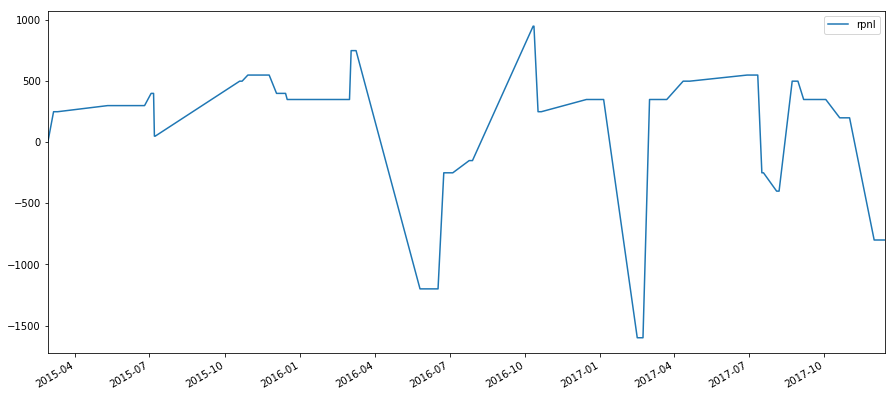

In [40]:
engine.df_rpnl.plot(figsize=(15,7))